In [1]:
import sys
sys.path.append("..")   # this allows us to import from sibling directory

import matplotlib.pyplot as plt  
import sklearn
from code_to_import.dataset_preprocessing import ProductionModeDataset

import torch
# from sklearn.inspection import permutation_importance
import numpy as np
import uproot
import torch.nn as nn
from matplotlib import pyplot as plt

from skorch import NeuralNetClassifier

from code_to_import.Classifier_module import Classifier
from code_to_import.Classifier_module import Three_Layer_Classifier
from code_to_import.Classifier_module import Two_Layer_Classifier
from code_to_import.Classifier_module import Five_Layer_Classifier
from torch.autograd import Variable


Using backend: pytorch


In [2]:
################# THIS IS WHERE YOU CHOOSE WHAT TO LOAD ################################

correlation_cut = -1.0   # if negative none, current other options are 0.9 and 0.8, but more can be added

cut_version = -1   # -1 means OG, otherwise can be 2 or 3 (or more if added)

event_type = "ee"  # could be ee, emu, mumu

weight_cmd = "true"   # could also be "false", "true" or "no-neg"

drop = 0.2  # drop rate

input_type = "lorentzdelta_gen"

qg_cmd = False

batch_size = 2000


layer_number = "five"
layer_num_type = "more"

#This is only here in case format is changed... should be good for all three layer stuff otherwise
model_name = layer_number + "LayerModel_" + event_type + "_corrCut_" + str(correlation_cut) + "_weights_" + weight_cmd + "_drop_" + str(drop)

if cut_version > 0:
    model_name += "cutV" + str(cut_version)

if input_type != "all":
    model_name += "_" + input_type
    
if not qg_cmd:
    model_name += "_no_qg"
    
if batch_size != -1:
    model_name += "batch_" + str(batch_size)
    
model_name +="_layerordergood"

In [3]:
model_name

'fiveLayerModel_ee_corrCut_-1.0_weights_true_drop_0.2_lorentzdelta_gen_no_qgbatch_2000_layerordergood'

In [4]:

    
# root_path = "/depot-new/cms/top/mcnama20/TopSpinCorr-Run2-Entanglement/CMSSW_10_2_22/src/TopAnalysis/Configuration/analysis/diLeptonic/three_files/Nominal"

# file = root_path + "/" + event_type + "_modified_root_1_spinCorr.root"

path_to_model = "../models/" + layer_num_type + "_layers/" + model_name + ".pt"

title = "confusion_plot_" + model_name

In [5]:
############### Create a production mode dataset object and get the validation dataset.############################
################## NOTE: THIS NEEDS TO BE REPLACED BY LOADING THE SAVED DATASET FOR MODEL #########################
# data_object = ProductionModeDataset(file)
# x = data_object.get_eval_data()

x = np.load("../data/" + layer_num_type + "_layers/train_val_datasets/validation_dataset_" + model_name + ".npy")


In [6]:
############ remove parts of dataset not used in nn input and get output goals (target) and weights ####################
l = x.shape[1]   # get the initial length of the validation dataset
weight = x[:,l-2]   # get an array of weights for plotting
target = x[:,l-3]   # get targets
target = Variable(torch.from_numpy(target).type(torch.LongTensor))   # reformate target into a tensor

######################### remove excess inputs from x and call new variable y
y = np.transpose(x)   
y = np.delete(y, [l-3, l-2, l-1], 0)
y = np.transpose(y)

# the final validation input is gotten from turning y into a tensor
input = Variable(torch.from_numpy(y).type(torch.Tensor))

In [7]:
############################## Load the model and run eval so we know to evaluate ##################################
# try:
#     model = Classifier()
#     model.load_state_dict(torch.load(path_to_model))
# except:
if layer_number == "three":
    if not qg_cmd:
        model = Three_Layer_Classifier(input_size=input.shape[1], number_of_classes=2)
    else: 
        model = Three_Layer_Classifier(input_size=input.shape[1])
    model.load_state_dict(torch.load(path_to_model))
elif layer_number == "two":
    if not qg_cmd:
        model = Two_Layer_Classifier(input_size=input.shape[1], number_of_classes=2)
    else: 
        model = Two_Layer_Classifier(input_size=input.shape[1])
    model.load_state_dict(torch.load(path_to_model))
elif layer_number == "five":
    if not qg_cmd:
        model = Five_Layer_Classifier(input_size=input.shape[1], number_of_classes=2)
    else: 
        model = Five_Layer_Classifier(input_size=input.shape[1])
    model.load_state_dict(torch.load(path_to_model))
model.eval()

Five_Layer_Classifier(
  (model): Sequential(
    (0): Linear(in_features=28, out_features=64, bias=True)
    (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Dropout(p=0.0, inplace=False)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Dropout(p=0.0, inplace=False)
    (8): Linear(in_features=128, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Dropout(p=0.0, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.2, inplace=True)
    (15): Dropout(

In [8]:
data  = model(input).detach().numpy()

data = data[:,1]

data =data/ max(np.abs(data))

data

array([-0.00417613,  0.18900031,  0.06687748, ..., -0.03034153,
       -0.01126488, -0.04955424], dtype=float32)

In [9]:
model(input).detach().numpy()


array([[-0.03142875, -0.0129513 ],
       [ 0.7990404 ,  0.58614135],
       [-0.4674513 ,  0.20740524],
       ...,
       [ 0.941988  , -0.09409734],
       [-0.16102503, -0.03493544],
       [ 0.32901472, -0.15368117]], dtype=float32)

In [10]:
target

tensor([1, 0, 1,  ..., 1, 1, 1])

In [11]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(target.detach().numpy(), data, sample_weight = weight)
auroc = sklearn.metrics.auc(fpr, tpr)

ValueError: x is neither increasing nor decreasing : [ 0.00000000e+00 -1.05380350e-04 -1.05380350e-04 ...  9.99909973e-01
  1.00000000e+00  1.00000000e+00].

In [12]:
fpr

array([ 0.00000000e+00, -1.05380350e-04, -1.05380350e-04, ...,
        9.99909973e-01,  1.00000000e+00,  1.00000000e+00])

In [13]:
tpr

array([ 0.00000000e+00, -0.00000000e+00,  1.04708187e-04, ...,
        9.99895402e-01,  9.99895402e-01,  1.00000000e+00])

In [14]:
thresholds

array([ 2.        ,  1.        ,  0.8457719 , ..., -0.25740132,
       -0.2681401 , -0.2693256 ], dtype=float32)

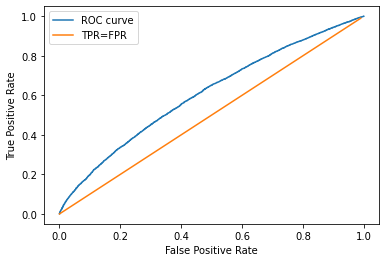

In [15]:
plt.plot(fpr, tpr, label='ROC curve')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), label='TPR=FPR')
plt.legend()


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

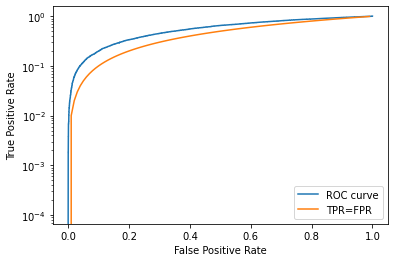

In [16]:
plt.plot(fpr, tpr, label='ROC curve')
plt.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), label='TPR=FPR')
plt.legend()
plt.yscale('log')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

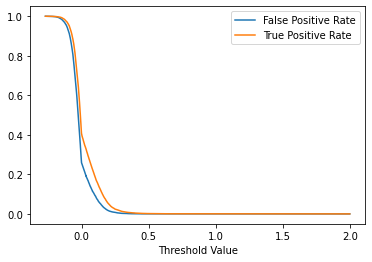

In [17]:

plt.plot(thresholds, fpr, label='False Positive Rate')
plt.plot(thresholds, tpr, label='True Positive Rate')
plt.xlabel('Threshold Value')
plt.legend()
plt.show()

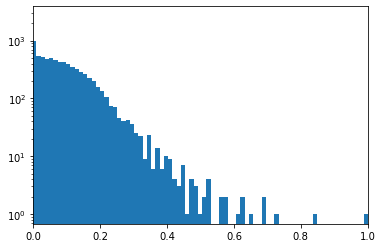

In [18]:
plt.hist(data, bins=100)
plt.yscale('log')

ax = plt.gca()
ax.set_xlim(0.0, 1.0)

plt.show()

In [28]:
data

array([-0.00417613,  0.18900031,  0.06687748, ..., -0.03034153,
       -0.01126488, -0.04955424], dtype=float32)

In [19]:
y_pred_test =  Variable(torch.from_numpy(data))

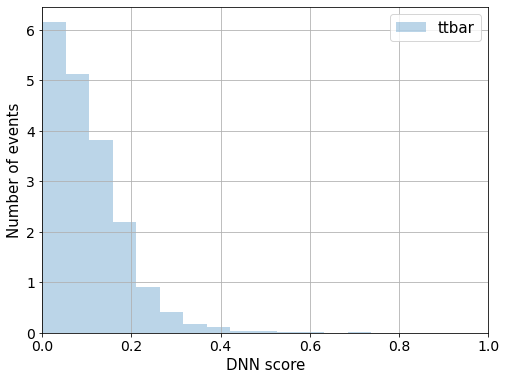

In [20]:
# # Predictions for signal and background
# tt_pred  = model.predict(tt_df_test) 
# si_pred  = model.predict(sig_df_test)

# # Set binning, tick size
binning = np.linspace(0, 1, 20)
plt.figure(figsize=(8,6))
plt.tick_params(axis="y", labelsize=14)
plt.tick_params(axis="x", labelsize=14)

# Now plot the model outputs
plt.hist(data, bins=binning, alpha=0.3, label='ttbar', density=True)
# plt.hist(si_pred, bins=binning, alpha=0.3, label='SUSY all', density=True)
#plt.yscale('log')
plt.xlim(0,1)
plt.xlabel('DNN score', fontsize=15)
plt.ylabel('Number of events', fontsize=15)
plt.grid()
plt.legend(loc='best', fontsize=15)
#plt.savefig('DNN score Mstop_235 Mchi_60.jpg')

In [21]:
y_pred_test = y_pred_test.reshape(len(y_pred_test))


In [22]:
target.shape

torch.Size([20105])

In [23]:
target.type

<function Tensor.type>

In [24]:
class_0_mask = torch.BoolTensor(target == 0)
class_1_mask = torch.BoolTensor(target == 1)

class_0_predictions = torch.masked_select(y_pred_test, class_0_mask).detach().numpy()
class_1_predictions = torch.masked_select(y_pred_test, class_1_mask).detach().numpy()

In [25]:
class_0_mask

tensor([False,  True, False,  ..., False, False, False])

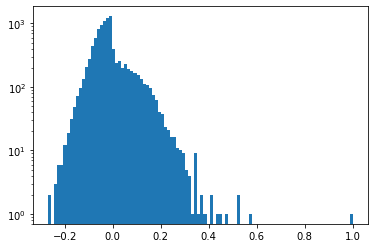

In [26]:
plt.hist([class_0_predictions], stacked=True, bins = 100)
plt.yscale('log')

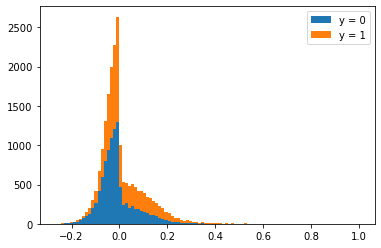

In [27]:
plt.hist([class_0_predictions, class_1_predictions], stacked=True, label=['y = 0', 'y = 1'], bins = 100)
# plt.hist(y_pred_test[test_labels == 0], color='red', label='$\hat{y} = 0', bins=10)
# plt.yscale('log')

# ax = plt.gca()
# ax.set_xlim(0.0, 1.0)

plt.legend()
plt.show()